# 神经网络构造
## 插入模块

In [1]:
import numpy as np
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import testCases 
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward 
import lr_utils 
np.random.seed(1)

## 初始化参数
对于一个L层的神经网络结构而言，模型结构是[线性->ReLU]*(L-1)->线性->sigmod函数

In [2]:
def initialize_parameters_deep(layers_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表

    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)#构建L层神经网络，layers_dims的长度应为L+1

    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])*0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        #确保我要的数据的格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))

    return parameters

## 前向传播
### 单层传播

#### 线性传播 

- LINEAR
- LINEAR - >ACTIVATION，其中激活函数将会使用ReLU或Sigmoid 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (整个模型)

 线性正向传播模块（向量化所有示例）使用公式(3)进行计算：

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$
 $A^{[0]} = X$. 


In [3]:
def linear_forward(A,W,b):
    """
    实现前向传播的线性部分。

    参数：
        A - 来自上一层（或输入数据）的激活，维度为(上一层的节点数量，示例的数量）
        W - 权重矩阵，numpy数组，维度为（当前图层的节点数量，前一图层的节点数量）
        b - 偏向量，numpy向量，维度为（当前图层节点数量，1）

    返回：
         Z - 激活功能的输入，也称为预激活参数
         cache - 一个包含“A”，“W”和“b”的元祖，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A,W,b)

    return Z,cache

#### 线性激活

In this notebook, you will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. 

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. 

- $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$


In [4]:
def linear_activation_forward(A_prev,W,b,activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的元祖，我们需要存储它以有效地计算后向传递
    """

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z) #sigmoid(Z)返回A和Z两个值
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z) #relu(Z)返回A和Z两个值

    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (linear_cache,activation_cache) #cache的形式((A_prev, W, b)，Z)

    return A,cache

### 多层传播

In [5]:
def L_model_forward(X,parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION

    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出，包含参数“W1”，“b1”，...，“WL”，“bL”的字典

    返回：
        AL - 最后的激活值 即yhat
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL,caches

## 计算成本

 $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [6]:
def compute_cost(AL,Y):
    """
    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m

    cost = np.squeeze(cost) #例如：确保 [[17]] 变为 17
    assert(cost.shape == ())

    return cost

## 反向传播
### 单层传播
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">

#### 线性部分
<img src="images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center> **Figure 4** </center></caption>

$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [8]:
def linear_backward(dZ,cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

#### 线性激活部分

In [9]:
def linear_activation_backward(dA,cache,activation="relu"):
    """
    实现LINEAR-> ACTIVATION层的后向传播。

    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev,dW,db

### 多层传播
<img src="images/mn_backward.png" style="width:450px;height:300px;">
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 

In [10]:
def L_model_backward(AL,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播

    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache

    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

## 更新参数
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

In [11]:
def update_parameters(parameters, grads, learning_rate):
    """
    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出

    返回：
     parameters - 包含更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters) // 2 #整除
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

## 模型整合

In [12]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。

    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱

    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)

        cost = compute_cost(AL,Y)

        grads = L_model_backward(AL,Y,caches)

        parameters = update_parameters(parameters,grads,learning_rate)

        #打印成本值，如果print_cost=False则忽略
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
    #迭代完成，根据条件绘制图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 模型预测

In [13]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层

    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数

    返回：
     p - 给定数据集X的预测
    """

    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))

    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("准确度为: "  + str(float(np.sum((p == y))/m)))

    return p

# 数据获取

In [14]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y


y = 0. It's a non-cat picture.
train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


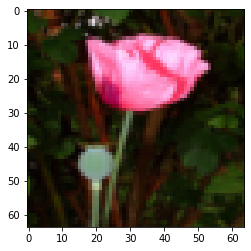

In [15]:
#数据可视化
index = 30
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

# 训练

Cost after iteration 0: 0.692380
Cost after iteration 100: 0.646159
Cost after iteration 200: 0.631775
Cost after iteration 300: 0.600091
Cost after iteration 400: 0.559427
Cost after iteration 500: 0.512988
Cost after iteration 600: 0.454815
Cost after iteration 700: 0.399388
Cost after iteration 800: 0.420515
Cost after iteration 900: 0.369184
Cost after iteration 1000: 0.362393
Cost after iteration 1100: 0.341366
Cost after iteration 1200: 0.333344
Cost after iteration 1300: 0.263797
Cost after iteration 1400: 0.164805
Cost after iteration 1500: 0.143608
Cost after iteration 1600: 0.124467
Cost after iteration 1700: 0.706752
Cost after iteration 1800: 0.092394
Cost after iteration 1900: 0.078572
Cost after iteration 2000: 0.068092
Cost after iteration 2100: 0.059649
Cost after iteration 2200: 0.052619
Cost after iteration 2300: 0.046817
Cost after iteration 2400: 0.041928


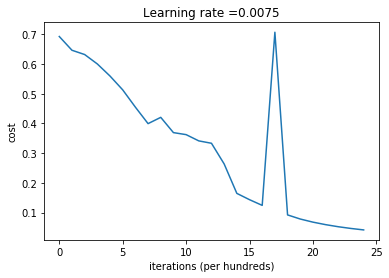

准确度为: 1.0
准确度为: 0.72


In [16]:
#计算正确率
layers_dims = [12288,7,1]  #  4-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

# 预测

In [16]:
def pred(my_image):
    img=Image.open(my_image)
    adjust_img=img.resize((64,64),Image.BILINEAR)
    a=np.array(adjust_img)
    X=a.reshape(a.shape[0]**2*3,1)/225

    yhat, caches = L_model_forward(X, parameters)
    
    if yhat > 0.5:
        print('yhat=1,your L-layer model predicts a cat picture')
    else:
        print('yhat=0,your L-layer model predicts a non-cat picture')

    plt.imshow(img)

yhat=1,your L-layer model predicts a cat picture


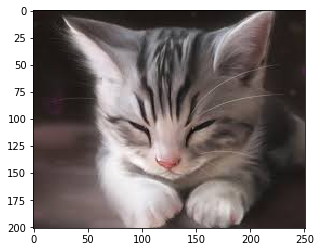

In [18]:
pred('images/download.jpg')